<a href="https://colab.research.google.com/github/geoffwoollard/prob_prog/blob/main/project/pyro_1D_sigmasignal_distofdist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip3 install pyro-ppl 

     |████████████████████████████████| 678 kB 8.0 MB/s 


In [88]:
import pyro
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd

def doplt(arr_2d): return plt.imshow(arr_2d, cmap='gray')
pyro.set_rng_seed(101)


# estimating width of atom

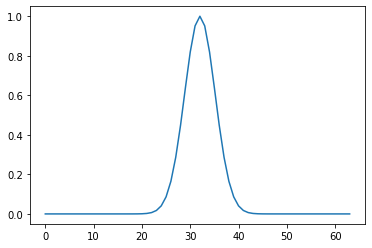

In [310]:
num_pix = 64
domain = torch.arange(-num_pix//2, num_pix//2)
sigma_signal_gt = torch.sqrt(torch.tensor(10.))
clean_signal = torch.exp(-domain**2/(2*sigma_signal_gt**2))
pd.Series(clean_signal).plot()

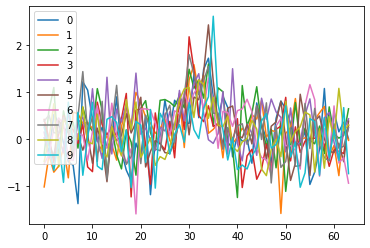

In [406]:
# synthetic data. normally, these would come from actual measurements and we would not know shift. h
# ere we have access to the ground truth
sigma_noise = 0.5
num_particles = 1000
data = torch.empty((num_particles,num_pix))
for i in range(num_particles):
  shift = 0#dist.Normal(0,2).sample()
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal_gt**2))
  data[i] = dist.Normal(clean_signal,sigma_noise).sample()
pd.DataFrame(data[:10].numpy().T).plot()

In [407]:
def model(data):
  batch_size=10
  shift = 0# pyro.sample('shift',dist.Normal(0,2))
  sigma_signal_mean = pyro.sample('sigma_signal_mean',dist.Normal(torch.tensor(3.1623)-1,1)) # biased model off from ground truth
  sigma_signal_std = pyro.sample('sigma_signal_std',dist.Normal(.1,0.01))
  sigma_signal = pyro.sample('sigma_signal',dist.Normal(sigma_signal_mean,torch.abs(sigma_signal_std)))
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal**2))
  with pyro.plate("data", size=len(data), subsample_size=batch_size) as ids:
    pyro.sample("particle_1d", dist.Normal(clean_signal, sigma_noise).to_event(1), obs=data[ids])

def guide(data): # the proposal distribution
  """
  learn the parameters of our modelled encoding of the signal (a 1D atom)
  hard coded fixed noise of 0.1
  """
  sigma_signal_mean_mean = pyro.param("sigma_signal_mean_mean", torch.tensor(3.1623-1),constraint=torch.distributions.constraints.positive) # biased guide (starting from) off from ground truth but matching model
  sigma_signal_mean_std = pyro.param("sigma_signal_mean_std", torch.tensor(1), constraint=torch.distributions.constraints.positive)  
  sigma_signal_std_mean = pyro.param("sigma_signal_std_mean", torch.tensor(0.1),constraint=torch.distributions.constraints.positive)
  sigma_signal_std_std = pyro.param("sigma_signal_std_std", torch.tensor(0.01), constraint=torch.distributions.constraints.positive)
  sigma_signal_mean = pyro.sample("sigma_signal_mean",dist.Normal(sigma_signal_mean_mean,sigma_signal_mean_std))
  sigma_signal_std= pyro.sample("sigma_signal_std",dist.Normal(sigma_signal_std_mean,sigma_signal_std_std))
  sigma_signal = pyro.sample("sigma_signal",dist.Normal(sigma_signal_mean,torch.abs(sigma_signal_std)))
  return sigma_signal

In [408]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, 
                     guide=guide, 
                     optim=pyro.optim.Adam({"lr": 0.01}), 
                     loss=pyro.infer.Trace_ELBO())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
sigma_signal_mean_mean =  3.2084527015686035
sigma_signal_mean_std =  0.026981916278600693
sigma_signal_std_mean =  0.08654654026031494
sigma_signal_std_std =  0.009088714607059956


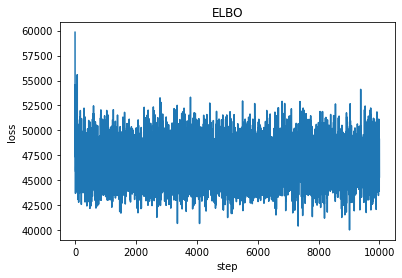

In [409]:
losses, sigma_signal_mean_mean, sigma_signal_mean_std,  sigma_signal_std_mean, sigma_signal_std_std  = [], [], [],[],[]
num_epochs = 10000
for ep in range(num_epochs):
    if num_epochs < 10 or (ep%(num_epochs//10) == 0): print(ep)
    losses.append(svi.step(data[:]))
    sigma_signal_mean_mean.append(pyro.param("sigma_signal_mean_mean").item())
    sigma_signal_mean_std.append(pyro.param("sigma_signal_mean_std").item())
    sigma_signal_std_mean.append(pyro.param("sigma_signal_std_mean").item())
    sigma_signal_std_std.append(pyro.param("sigma_signal_std_std").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('sigma_signal_mean_mean = ',pyro.param("sigma_signal_mean_mean").item())
print('sigma_signal_mean_std = ',pyro.param("sigma_signal_mean_std").item())
print('sigma_signal_std_mean = ',pyro.param("sigma_signal_std_mean").item())
print('sigma_signal_std_std = ',pyro.param("sigma_signal_std_std").item())

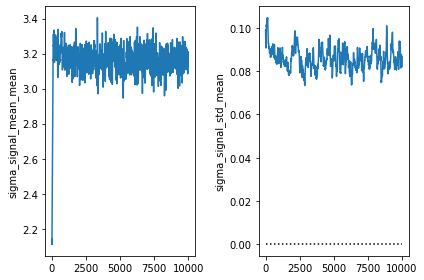

In [410]:
plt.subplot(1,2,1)
plt.plot([0,len(sigma_signal_mean_mean)],[sigma_signal_gt,sigma_signal_gt], 'k:')
plt.plot(sigma_signal_mean_mean)
plt.ylabel('sigma_signal_mean_mean')
plt.subplot(1,2,2)
plt.ylabel('sigma_signal_std_mean')
plt.plot([0,len(sigma_signal_std_mean)],[0.0,0.0], 'k:')
plt.plot(sigma_signal_std_mean)
plt.tight_layout() 